---
# Introducing `NideconvFitter`

This notebook illustrates how to perform a deconvolution using `nideconv` and specific classes from this repository. First, we read the data in with `linescanning.dataset.Dataset`, which formats our functional data and onset timings the way nideconv likes it. Then I show some useful functions to select specific portions of a larger dataframe. Then, we perform the fitting and do some plotting

In [1]:
# imports
from linescanning import dataset, plotting, utils
import warnings
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
import seaborn as sns

warnings.simplefilter('ignore')
project_dir     = "/mnt/d/FSL/shared/spinoza/projects"
base_dir        = opj(project_dir, 'hemifield')
deriv_dir       = opj(base_dir, 'derivatives')

plot_vox = 359
plot_xkcd = False

/home/gjheij/anaconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


Load in some data. You could substitute this with the example data provided with the repository. However, when I did the deconvolution on that data the results didn't look good enough for illustrative purposes. So I have a different dataset here: 3 runs of a Size-Response experiment in which our target pRF was bombarded with flickering stimuli of 5 different sizes.

In [2]:
    # Load data
sub         = '003'
ses         = 3
task        = "task-SR"
runs        = [3,4,6]
func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")
ribbon      = (356,363)

run_files = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}"], func_dir)
func_file   = utils.get_file_from_substring("bold.mat", run_files)
exp_file   = utils.get_file_from_substring("events.tsv", run_files)
func_file


['/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-3_bold.mat',
 '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-4_bold.mat',
 '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-6_bold.mat']

Here we plop everything in `Dataset`, which will automatically format the functional data and onset timings for us

In [6]:
window = 19
order = 3

## window 5 TR poly 2
data_obj = dataset.Dataset(func_file,
                           deleted_first_timepoints=0,
                           deleted_last_timepoints=0,
                           tsv_file=exp_file,
                           standardization="psc",
                           use_bids=True,
                           verbose=True)

df_func     = data_obj.fetch_fmri()
df_onsets   = data_obj.fetch_onsets()
df_func

DATASET

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-3_bold.mat
 Filtering strategy: 'hp'
 Standardization strategy: 'psc'
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-4_bold.mat
 Filtering strategy: 'hp'
 Standardization strategy: 'psc'
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-6_bold.mat
 Filtering strategy: 'hp'
 Standardization strategy: 'psc'
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]

EXPTOOLS
 1st 't' @153.63s
 Cutting 153.63s from onsets
 1st 't' @109.93s
 Cutting 109.93s from onsets
 1st 't' @117.54s
 Cutting 117.54s from onsets

DATASET: created
Fetching datafra

vox 0      vox 1     vox 2      vox 3     vox 4  \
subject run t                                                              
003     3   0.000   -27.101469 -18.751007 -3.140438  -5.989230 -8.952475   
            0.105    14.714849 -12.603736 -7.922297   0.157583  0.097644   
            0.210   -19.790285  10.353661 -9.093881   4.996634 -2.729607   
            0.315    -5.779219   0.189471 -3.321713   5.286038 -2.555609   
            0.420     6.755626  -7.892859  2.910602  -4.236454 -5.104291   
...                        ...        ...       ...        ...       ...   
        6   461.475  -9.425747  -0.683254 -6.643206  -4.047709  4.750955   
            461.580  -6.395483  -0.730556 -6.528580   4.124105 -0.087732   
            461.685   9.204924   3.650904  1.499987  14.070166  8.353365   
            461.790  -3.592962  -1.695049  4.680800  11.170662 -2.809829   
            461.895  -1.599383  -6.005609 -3.943110  -4.435963  4.484248   

                         vox 5      vox 6      vox 7      vox 8      vox 9  \
subject run t                                                                
003     3   0.000    -7.318276  -7.743126 -17.468149 -12.644779  -5.677361   
            0.105   -15.488953   3.858423  -9.013165   1.845956 -10.781849   
            0.210     0.016534   9.707891   3.151488  -7.475281  -0.723851   
            0.315    -3.346759  -6.301332  -6.739325  -7.645625 -15.771270   
            0.420     6.119144   8.817112  -0.115031  -1.171863  -9.876532   
...                        ...        ...        ...        ...        ...   
        6   461.475 -18.013483   7.575595  -7.695645   4.355752  -3.021979   
            461.580  -5.055266  -8.291989   1.437294  -3.740090   2.003622   
            461.685  -8.563196   3.739870   6.782091   4.138100  -5.031323   
            461.790   4.653215   2.416098   5.377018   1.129675   6.395006   
            461.895  -4.157913 -13.986665   2.462184  -3.211385  -1.705122   

                     ...    vox 710    vox 711    vox 712    vox 713  \
subject run t        ...                                               
003     3   0.000    ... -17.767693 -11.346096 -34.399460 -11.942273   
            0.105    ... -23.421162   4.552734 -14.338583  -2.703935   
            0.210    ... -13.858581 -24.453146  -1.416743  33.039440   
            0.315    ...   4.312015  26.885044   9.741699  -4.463572   
            0.420    ...  33.529045  15.396202   9.551632  -4.378814   
...                  ...        ...        ...        ...        ...   
        6   461.475  ...  18.424952  48.845078  -8.145041  46.799480   
            461.580  ...   0.723040  57.425179  19.464588  30.489290   
            461.685  ... -16.706770  -1.533198   0.221753  -9.740692   
            461.790  ...  30.031347  20.289707 -21.445488   9.076953   
            461.895  ...  13.970720  21.999037   0.027192 -35.671818   

                       vox 714    vox 715    vox 716    vox 717    vox 718  \
subject run t                                                                
003     3   0.000    56.732201  32.460629  -2.556753  25.115799   5.792701   
            0.105     6.857896 -15.827542  27.126085 -18.522537  51.225998   
            0.210   -10.322868   5.662084 -34.340836   5.488515 -14.156712   
            0.315   -34.936756   2.420461 -55.797787 -21.884161 -13.233274   
            0.420   -23.168468  -4.199654  11.799276 -21.938705  13.147688   
...                        ...        ...        ...        ...        ...   
        6   461.475  -2.265441  27.682293 -18.772120 -44.543934 -19.056623   
            461.580 -10.495955 -23.788982  -6.807971 -14.222157 -19.808769   
            461.685  20.719601 -31.343662  17.868269 -12.028969 -19.267851   
            461.790 -18.782944  -1.192456  36.939121  -2.954715 -46.325600   
            461.895  18.696356 -17.927355  29.719521  19.573189 -30.326355   

                       vox 719  
subject run t                   
003

Now we have our data formatted the way `nideconv` likes it: the functional data is indexed by `subject`, `run`, and `t`, while the onset dataframe is indexed by `subject`, `run`, and `event_type`:

In [16]:
df_func.head()


vox 0      vox 1     vox 2     vox 3     vox 4  \
subject run t                                                           
003     3   0.000 -27.101469 -18.751007 -3.140438 -5.989230 -8.952475   
            0.105  14.714849 -12.603736 -7.922297  0.157583  0.097644   
            0.210 -19.790285  10.353661 -9.093881  4.996634 -2.729607   
            0.315  -5.779219   0.189471 -3.321713  5.286038 -2.555609   
            0.420   6.755626  -7.892859  2.910602 -4.236454 -5.104291   

                       vox 5     vox 6      vox 7      vox 8      vox 9  ...  \
subject run t                                                            ...   
003     3   0.000  -7.318276 -7.743126 -17.468149 -12.644779  -5.677361  ...   
            0.105 -15.488953  3.858423  -9.013165   1.845956 -10.781849  ...   
            0.210   0.016534  9.707891   3.151488  -7.475281  -0.723851  ...   
            0.315  -3.346759 -6.301332  -6.739325  -7.645625 -15.771270  ...   
            0.420   6.119144  8.817112  -0.115031  -1.171863  -9.876532  ...   

                     vox 710    vox 711    vox 712    vox 713    vox 714  \
subject run t                                                              
003     3   0.000 -17.767693 -11.346096 -34.399460 -11.942273  56.732201   
            0.105 -23.421162   4.552734 -14.338583  -2.703935   6.857896   
            0.210 -13.858581 -24.453146  -1.416743  33.039440 -10.322868   
            0.315   4.312015  26.885044   9.741699  -4.463572 -34.936756   
            0.420  33.529045  15.396202   9.551632  -4.378814 -23.168468   

                     vox 715    vox 716    vox 717    vox 718    vox 719  
subject run t                                                             
003     3   0.000  32.460629  -2.556753  25.115799   5.792701 -15.058589  
            0.105 -15.827542  27.126085 -18.522537  51.225998 -57.432533  
            0.210   5.662084 -34.340836   5.488515 -14.156712  -9.732580  
            0.315   2.420461 -55.797787 -21.884161 -13.233274  28.068913  
            0.420  -4.199654  11.799276 -21.938705  13.147688  -9.410250  

[5 rows x 720 columns]

In [18]:
df_onsets.head()

onset
subject run event_type                  
003     3   2.014613132977678  29.613776
            3.5652478065289    40.463706
            2.13914868391734   45.163720
            3.5652478065289    52.663652
            2.014613132977678  58.463640

Theoretically, `nideconv` should be able to concatenate multiple runs. Unfortunately, I haven't been able to get this to work yet, so what you can do instead is run the fitter for separate runs and then average the results. Alternatively, you can concatenate the runs yourself, but that becomes tricky with onset times (maybe I should implement such an option in `linescanning.dataset.Dataset`..). 

In any case, you can select portions of dataframes using `utils.select_from_df` given an expression. This expression is written in the form of how you say it. For instance: "_I want the data of subject 1 and run 1_", you'd specify: `utils.select_from_df(<dataframe>, expression=("subject = 1", "and", "run = 1"))`. The spaces in the expression are mandatory, as well as a separate operator in case you have multiple conditions. This is because, internally, the operator must be converted from string to operator-function. 

If your dataframe was indexed, you'll be returned a subset of the dataframe conform your expression with the same indexing.

In [14]:
# this is a bit simple because we only have 3 run in this dataset, but it illustrates the principle
utils.select_from_df(df_func, expression="run = 3")

vox 0      vox 1     vox 2     vox 3     vox 4  \
subject run t                                                             
003     3   0.000   -27.101469 -18.751007 -3.140438 -5.989230 -8.952475   
            0.105    14.714849 -12.603736 -7.922297  0.157583  0.097644   
            0.210   -19.790285  10.353661 -9.093881  4.996634 -2.729607   
            0.315    -5.779219   0.189471 -3.321713  5.286038 -2.555609   
            0.420     6.755626  -7.892859  2.910602 -4.236454 -5.104291   
...                        ...        ...       ...       ...       ...   
            461.475  20.314943  -4.389715 -6.580668  9.773469 -2.265954   
            461.580 -18.855255  -7.310855  1.137042  2.205122  3.724790   
            461.685   7.859588  14.253044 -1.508623  3.715765 -0.411671   
            461.790  -0.637245   0.062311  8.093584  2.939630  8.366644   
            461.895  14.630901  -9.111953  3.227139  0.301754 -0.886989   

                         vox 5      vox 6      vox 7      vox 8      vox 9  \
subject run t                                                                
003     3   0.000    -7.318276  -7.743126 -17.468149 -12.644779  -5.677361   
            0.105   -15.488953   3.858423  -9.013165   1.845956 -10.781849   
            0.210     0.016534   9.707891   3.151488  -7.475281  -0.723851   
            0.315    -3.346759  -6.301332  -6.739325  -7.645625 -15.771270   
            0.420     6.119144   8.817112  -0.115031  -1.171863  -9.876532   
...                        ...        ...        ...        ...        ...   
            461.475   1.177299  -2.334410   0.272405 -16.760128   4.538834   
            461.580  -1.069075   5.947387  -0.051987   8.619940   0.445271   
            461.685  12.864744   4.248643  16.132175  -2.542239   1.501691   
            461.790   5.670500  13.312268   2.735627   4.680669   9.617340   
            461.895   3.518891  -6.604081   2.100098  -9.913367  11.341513   

                     ...    vox 710    vox 711    vox 712    vox 713  \
subject run t        ...                                               
003     3   0.000    ... -17.767693 -11.346096 -34.399460 -11.942273   
            0.105    ... -23.421162   4.552734 -14.338583  -2.703935   
            0.210    ... -13.858581 -24.453146  -1.416743  33.039440   
            0.315    ...   4.312015  26.885044   9.741699  -4.463572   
            0.420    ...  33.529045  15.396202   9.551632  -4.378814   
...                  ...        ...        ...        ...        ...   
            461.475  ...  15.462458 -20.535934  -0.280291  -9.603083   
            461.580  ... -46.772766  21.157324  44.528378  49.731518   
            461.685  ...  -9.210629 -22.539770 -29.441906  -0.543845   
            461.790  ... -26.301754  20.269453   9.831154 -50.044777   
            461.895  ... -23.717392 -11.216688  41.867245  -4.341966   

                       vox 714    vox 715    vox 716    vox 717    vox 718  \
subject run t                                                                
003     3   0.000    56.732201  32.460629  -2.556753  25.115799   5.792701   
            0.105     6.857896 -15.827542  27.126085 -18.522537  51.225998   
            0.210   -10.322868   5.662084 -34.340836   5.488515 -14.156712   
            0.315   -34.936756   2.420461 -55.797787 -21.884161 -13.233274   
            0.420   -23.168468  -4.199654  11.799276 -21.938705  13.147688   
...                        ...        ...        ...        ...        ...   
            461.475 -23.433250  27.537037 -14.259571 -30.289291 -27.133232   
            461.580  19.100739  -6.992751  10.730481 -21.384823 -12.704981   
            461.685  -2.575606  56.296669  23.139656  29.052555   2.094877   
            461.790  18.844461  23.066341  30.598509  -7.255292 -19.105833   
            461.895  45.773579 -15.149575  29.885542 -14.988750 -24.906857   

                       vox 719  
subject run t                   
003     3   0.00

We can also select only the voxels from the GM-ribbon. For convenience, we'll continue with this subset of the dataframe for our fitting

In [15]:
df_ribbon = utils.select_from_df(df_func, expression='ribbon', indices=ribbon)
df_ribbon


vox 356   vox 357   vox 358   vox 359   vox 360  \
subject run t                                                           
003     3   0.000   -2.354032 -4.174930 -2.635247 -0.671780 -1.676673   
            0.105   -2.695900 -0.269616 -1.120222 -1.319355  0.089192   
            0.210    3.426528  3.724182  4.043782  5.321062 -0.317991   
            0.315   -2.434826  0.147414  2.198374 -2.460140 -0.757653   
            0.420    1.388657 -0.878322 -0.894356  1.506066  2.942038   
...                       ...       ...       ...       ...       ...   
        6   461.475  2.921450  2.243268  2.970123  1.032639  3.360045   
            461.580 -1.042616 -0.590765 -0.823289  2.139032 -1.568723   
            461.685  2.744949  1.075304  1.128817  2.268815  5.277598   
            461.790  2.335942  2.216113  1.698363  3.321326  0.890911   
            461.895 -0.366247 -0.696075  0.823486 -1.002723  4.348242   

                      vox 361   vox 362  
subject run t                            
003     3   0.000    3.302777 -2.105677  
            0.105    1.432824  0.053298  
            0.210    6.734896  6.217158  
            0.315    0.676346 -1.583350  
            0.420   -0.515115  3.556037  
...                       ...       ...  
        6   461.475 -0.334144  1.365578  
            461.580  2.936542  1.373494  
            461.685  1.500285  1.768756  
            461.790  1.604331  1.001894  
            461.895  1.181650  0.032747  

[13600 rows x 7 columns]

In [ ]:
# this also works for onset dataframes
utils.select_from_df(df_onsets, expression="run = 3")

Right, on to the fitting: we can do the fitting with `utils.NideconvFitter`, which requires the functional dataframe, onset dataframe, and some settings on the type of fit you'd like to do, number of regressors, confounds, etc

In [24]:
nd_fit = utils.NideconvFitter(df_ribbon,
                              df_onsets,
                              basis_sets='canonical_hrf_with_time_derivative',
                            #   n_regressors=4,
                              lump_events=False,
                              TR=0.105,
                              interval=[0,12],
                              add_intercept=True,
                              verbose=True)

Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '1.140879298089248' to model
Adding event '1.853928859395028' to model
Adding event '2.014613132977678' to model
Adding event '2.13914868391734' to model
Adding event '3.5652478065289' to model
Fitting with 'ols' minimization
Done


With `plot_average_per_event`, we can plot the average response across the voxels in the dataframe for each event in the model:

None


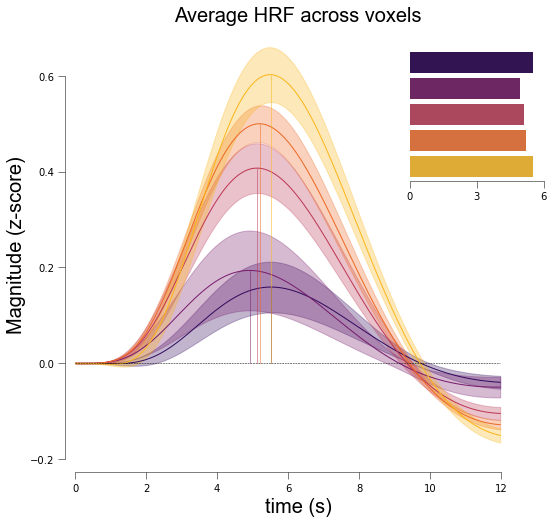

In [26]:
nd_fit.plot_average_per_event(xkcd=plot_xkcd, 
                              alpha=0.2,  
                              x_label="time (s)",
                              y_label="Magnitude (z-score)",
                              add_hline='default',
                              sns_trim=True,
                              ttp=True,
                              lim=[0, 6],
                              ticks=[0, 3, 6],
                              ttp_lines=True,
                              cmap='inferno')


.. note:: Using `**kwargs`, we can specify any argument that `plotting.LazyPlot` accepts. This means we can specify any argument in any of the plotting functions contained in the class

We can also plot all events for individual voxel in the dataframe (mind you, if you have 720 voxels, you'll get that many plots. That's a bit of an overkill):

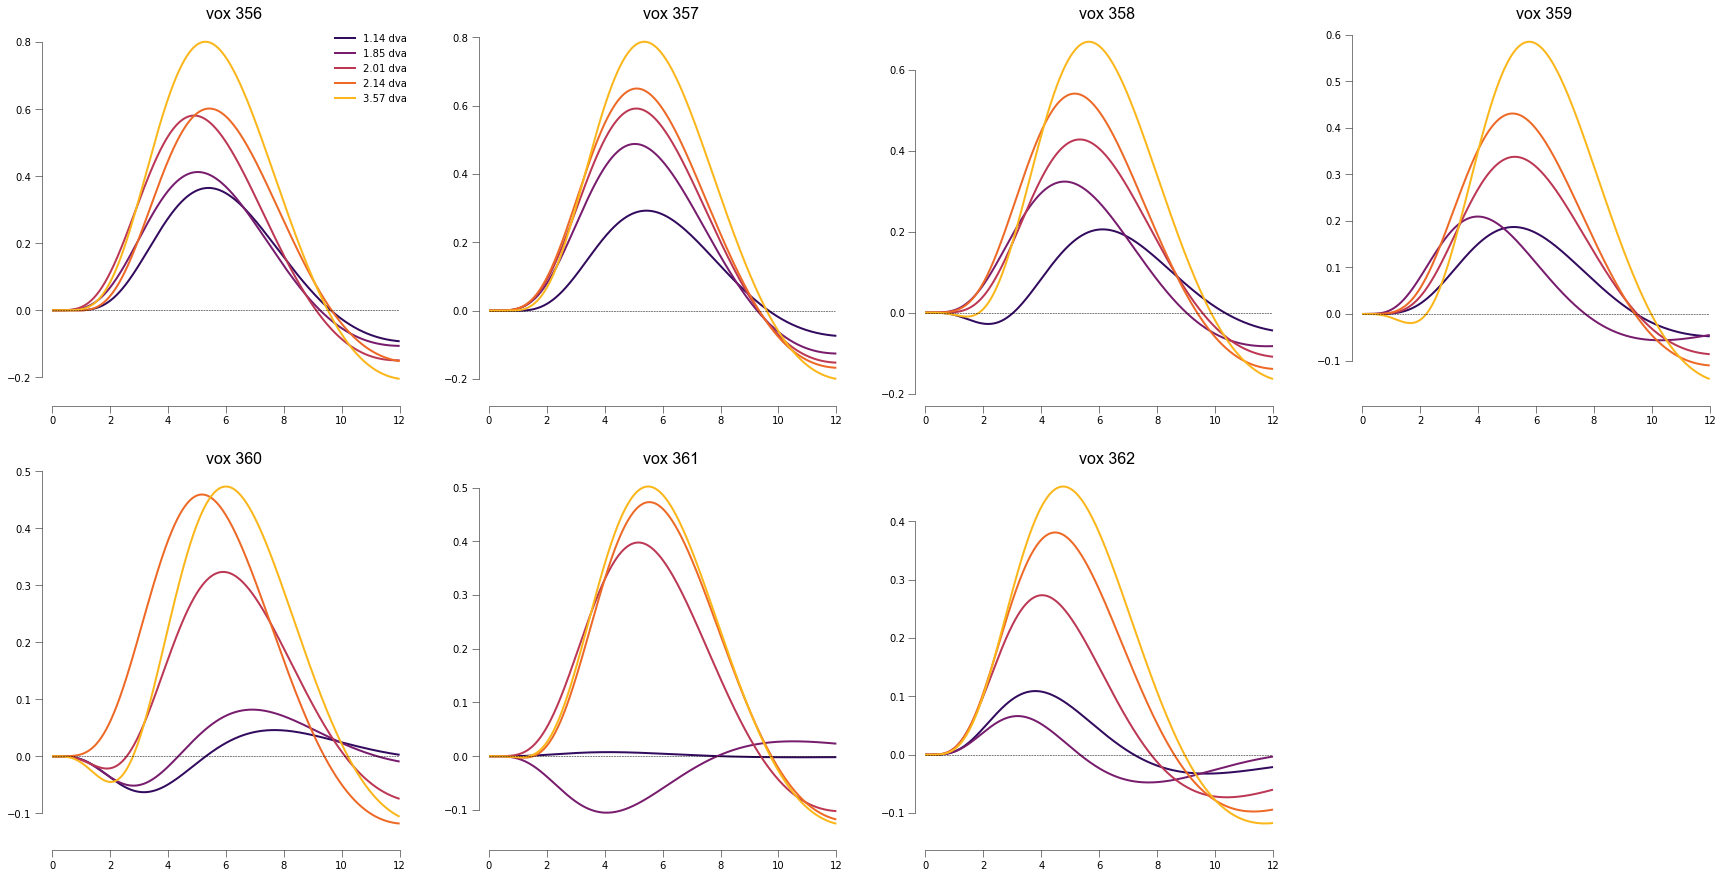

In [27]:
nd_fit.plot_average_per_voxel(xkcd=plot_xkcd, 
                              labels=[f"{round(float(ii),2)} dva" for ii in nd_fit.cond], 
                              wspace=0.2,
                              sns_trim=True,
                              cmap="inferno",
                              line_width=2)

Above, we defined each stimulus size as separate event. To investigate a global response, we can also lump all the events together using `lump_events=True`. This means we'll interpret *any* event as 1 event:

In [29]:
lumped = utils.NideconvFitter(df_ribbon,
                              df_onsets,
                              confounds=None,
                              basis_sets='fourier',
                              n_regressors=4,
                              lump_events=True,
                              TR=0.105,
                              interval=[0,12],
                              add_intercept=True,
                              verbose=True)

Selected 'fourier'-basis sets
Adding event 'stim' to model
Fitting with 'ols' minimization
Done


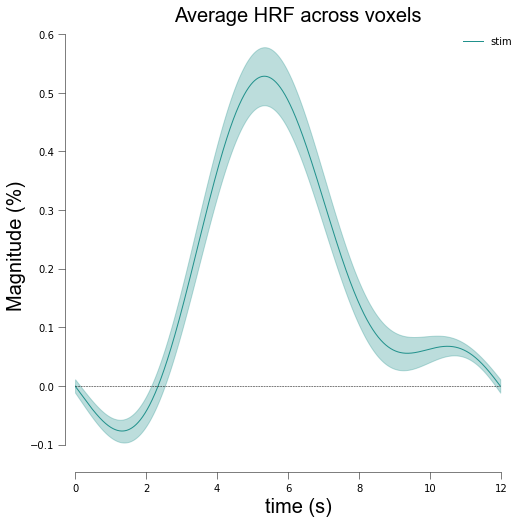

In [30]:
# plot average across voxels
lumped.plot_average_per_event(xkcd=plot_xkcd, 
                              labels=['stim'],
                              figsize=(8,8),
                              x_label="time (s)",
                              y_label="Magnitude (%)",
                              add_hline='default')


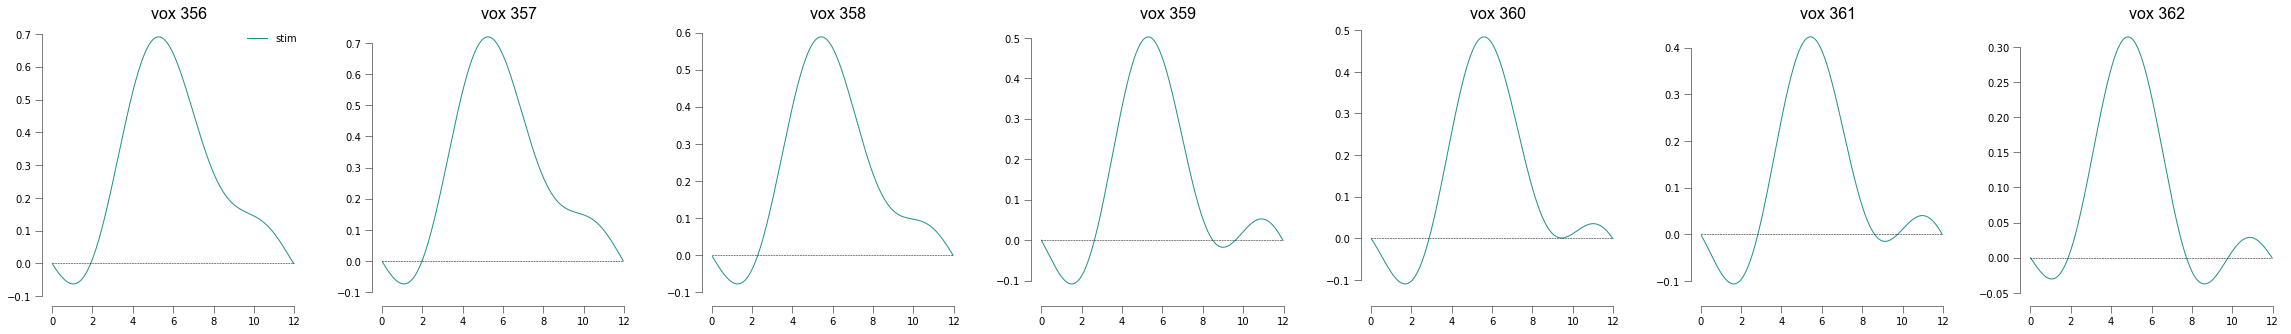

In [31]:
# plot individual voxels in separete figures
lumped.plot_average_per_voxel(xkcd=plot_xkcd, 
                              labels=['stim'], 
                              n_cols=7, 
                              figsize=(40,5),
                              wspace=0.3)

With this lumped-event model, we can also plot the HRFs across depth, independent of stimulus size (left plot). We can then extract the maximums of all HRFs and fit a polynomial to it, revealing a trend towards decreased HRF-amplitude when going from CSF/GM to GM/WM borders

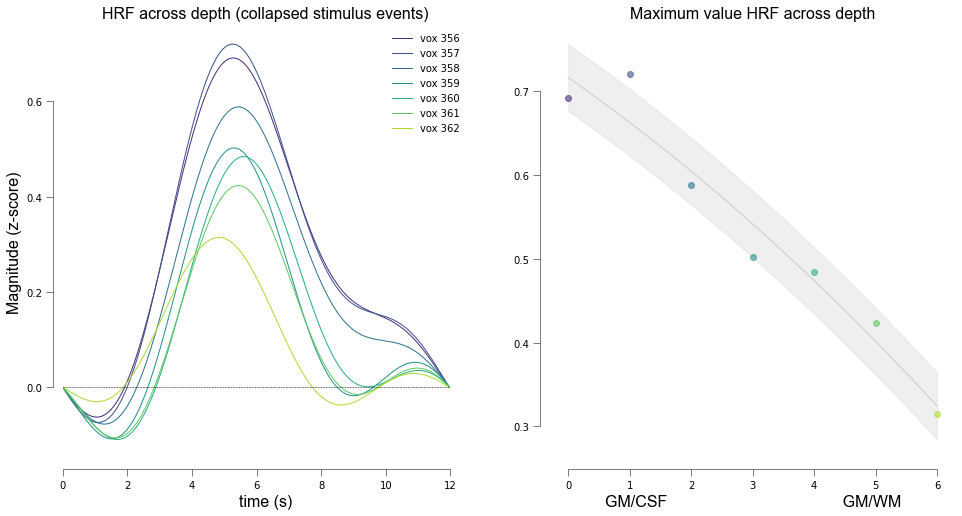

In [33]:
# plot individual voxels in 1 figure
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(1, 2)

ax = fig.add_subplot(gs[0])
lumped.plot_average_per_voxel(xkcd=plot_xkcd, 
                              n_cols=None, 
                              figsize=(8,8), 
                              axs=ax, 
                              labels=True,
                              title="HRF across depth (collapsed stimulus events)",
                              x_label="time (s)",
                              y_label="Magnitude (z-score)")

ax = fig.add_subplot(gs[1])
lumped.plot_hrf_across_depth(xkcd=plot_xkcd, 
                             axs=ax, 
                             title="Maximum value HRF across depth",
                             x_label="GM/CSF                                       GM/WM",
                             set_xlim_zero=False) #,
                            #  y_lim=[0.1,0.35])
